# Interpreting BERT Models (Part 2)

In the second part of interpreting Bert models we look into attention matrices, their importance scores, vector norms and compare them with the results that we found in Part 1.

Similar to Part 1 we use Bert Question Answering model fine-tuned on SQUAD dataset using transformers library from Hugging Face: https://huggingface.co/transformers/

In order to be able to use the same setup and reproduce the results form Part 1 we will redefine same setup and helper functions in this tutorial as well. 

In this tutorial we compare attention matrices with their importance scores when we attribute them to a particular class, and vector norms as proposed in paper: https://arxiv.org/pdf/2004.10102.pdf

We show that the importance scores computed for the attention matrices and specific class are more meaningful than the attention matrices alone or different norm vectors computed for different input activations.

Note: Before running this tutorial, please install `seaborn`, `pandas` and `matplotlib`, `transformers`(from hugging face) python packages in addition to `Captum` and `torch` libraries.

In [1]:
import os
import sys

sys.path.append("/home/narine/local/captum")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

The first step is to fine-tune BERT model on SQUAD dataset. This can be easiy accomplished by following the steps described in hugging face's official web site: https://github.com/huggingface/transformers#run_squadpy-fine-tuning-on-squad-for-question-answering 

Note that the fine-tuning is done on a `bert-base-uncased` pre-trained model.

After we pretrain the model, we can load the tokenizer and pre-trained BERT model using the commands described below. 

In [3]:
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = '/home/narine/local/debug_squad2'

# load model
model = BertForQuestionAnswering.from_pretrained(model_path, output_attentions=True)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

A helper function to perform forward pass of the model and make predictions.

In [4]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    return model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )

Defining a custom forward function that will allow us to access the start and end postitions of our prediction using `position` input argument.

In [5]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

Let's define some variables and functions that will help us to compute the attribution of attention matrices for specific output such as start or end positions of the prediction.

To do so, we need to define baselines / references, numericalize both the baselines and the inputs. We will define helper functions to achieve that.

The cell below defines numericalized special tokens that will be later used for constructing inputs and corresponding baselines/references.

In [6]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

Below we define a set of helper function for constructing references / baselines for word tokens, token types and position ids.

In [7]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)
    
def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    
    return input_embeddings, ref_input_embeddings


Let's define the `question - text` pair that we'd like to use as an input for our Bert model and interpret what the model was forcusing on when predicting an answer to the question from given input text 

In [8]:
question, text = "What is important to us?", "It is important to us to include, empower and support humans of all kinds."


Let's numericalize the question, the input text and generate corresponding baselines / references for all three sub-embeddings (word, token type and position embeddings) types using our helper functions defined above.

In [9]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Also, let's define the ground truth for prediction's start and end positions.

In [10]:
ground_truth = 'to include, empower and support humans of all kinds'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

Now let's make predictions using input, token type, position id and a default attention mask.

In [11]:
start_scores, end_scores, output_attentions = predict(input_ids,
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))


Question:  What is important to us?
Predicted Answer:  to include , em ##power and support humans of all kinds


# Visualizing Attention Matrices

`output_attentions` represent attention matrices aka attention probabilities for all 12 layers and all 12 heads. It represents softmax-normalized dot-product between the key and query vectors. In the literature (https://www.aclweb.org/anthology/W19-4828.pdf) it has been used as an importance indicator of how much a token attends / relates to another token in the text. In case of translation for example it is a good indicator of how much a token in one language attends to the corresponding translation in another language. In case of Question Answering model it indicates which tokens attend / relate to each other in question, text or answer segment.

Since `output_attentions` contains the layers in a list, we will stack them in order to move everything into a tensor.

In [12]:
# shape -> layer x batch x head x seq_len x seq_len
output_attentions_all = torch.stack(output_attentions)


#### A helper function for visualizing Token-To-Token matices

Below helper function will be used for visualizing token-to-token relation / attention scores for all heads in a given layer or for all layers across all heads.

In [13]:
def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(all_tokens)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(all_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

#### A helper function for visualizing Token-To-Head matrices

Below helper function will be used for visualizing the importance scores for tokens across all heads in all layers.

In [14]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(all_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(all_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

Let's examine a specific layer. For that reason we will define a fixed layer id that will be used for visualization purposes. The users are free to change this layer if they want to examine a different one.


In [15]:
layer = 11

Visualizing attention matrices for a selected layer `layer`. 

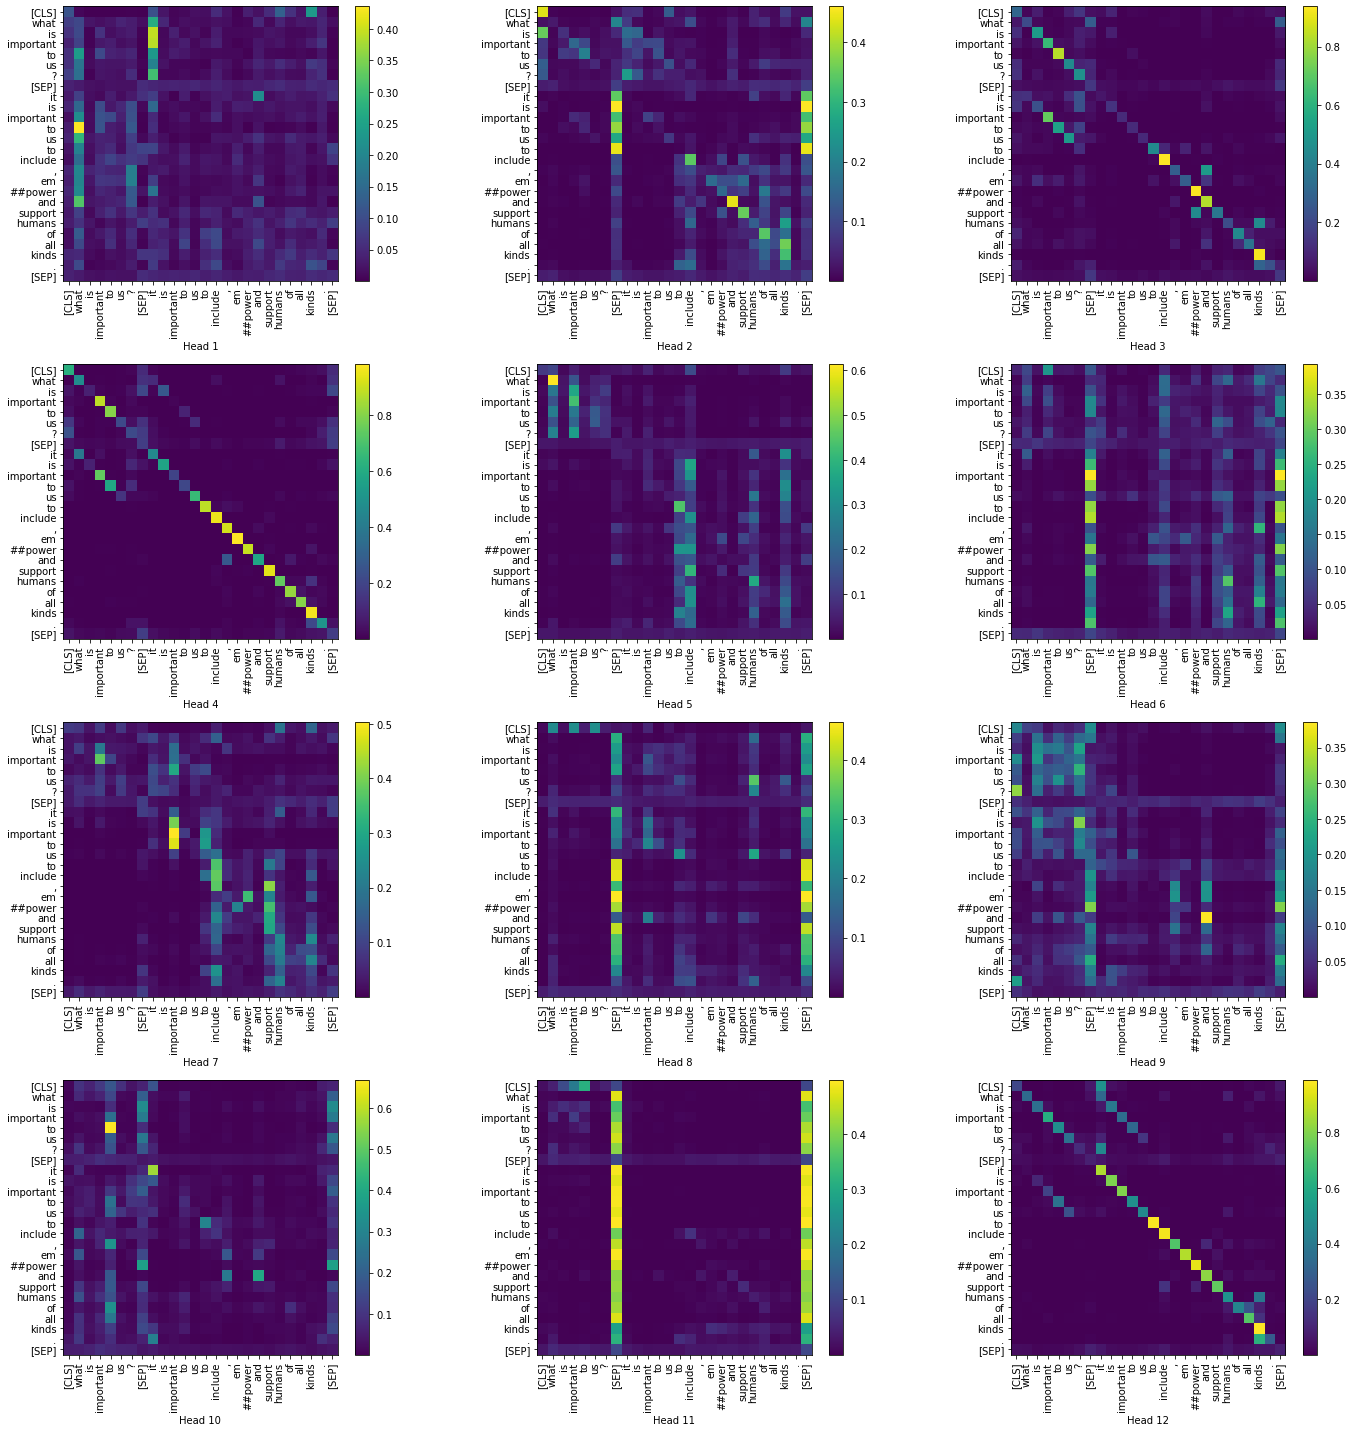

In [16]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

Based on the visualizations above we observe that there is a high attention set along the diagonals and on an uninformative token such as `[SEP]`. This is something that was observed in previous papers which indicates that attention matrices aren't always a good indicator of finding which tokens are more important or which token is related to which. We observe similar pattern when we examine another layer.

In the cell below we compute and visualize L2 norm across head axis for all 12 layer. This provides a summary for each layer across all heads.

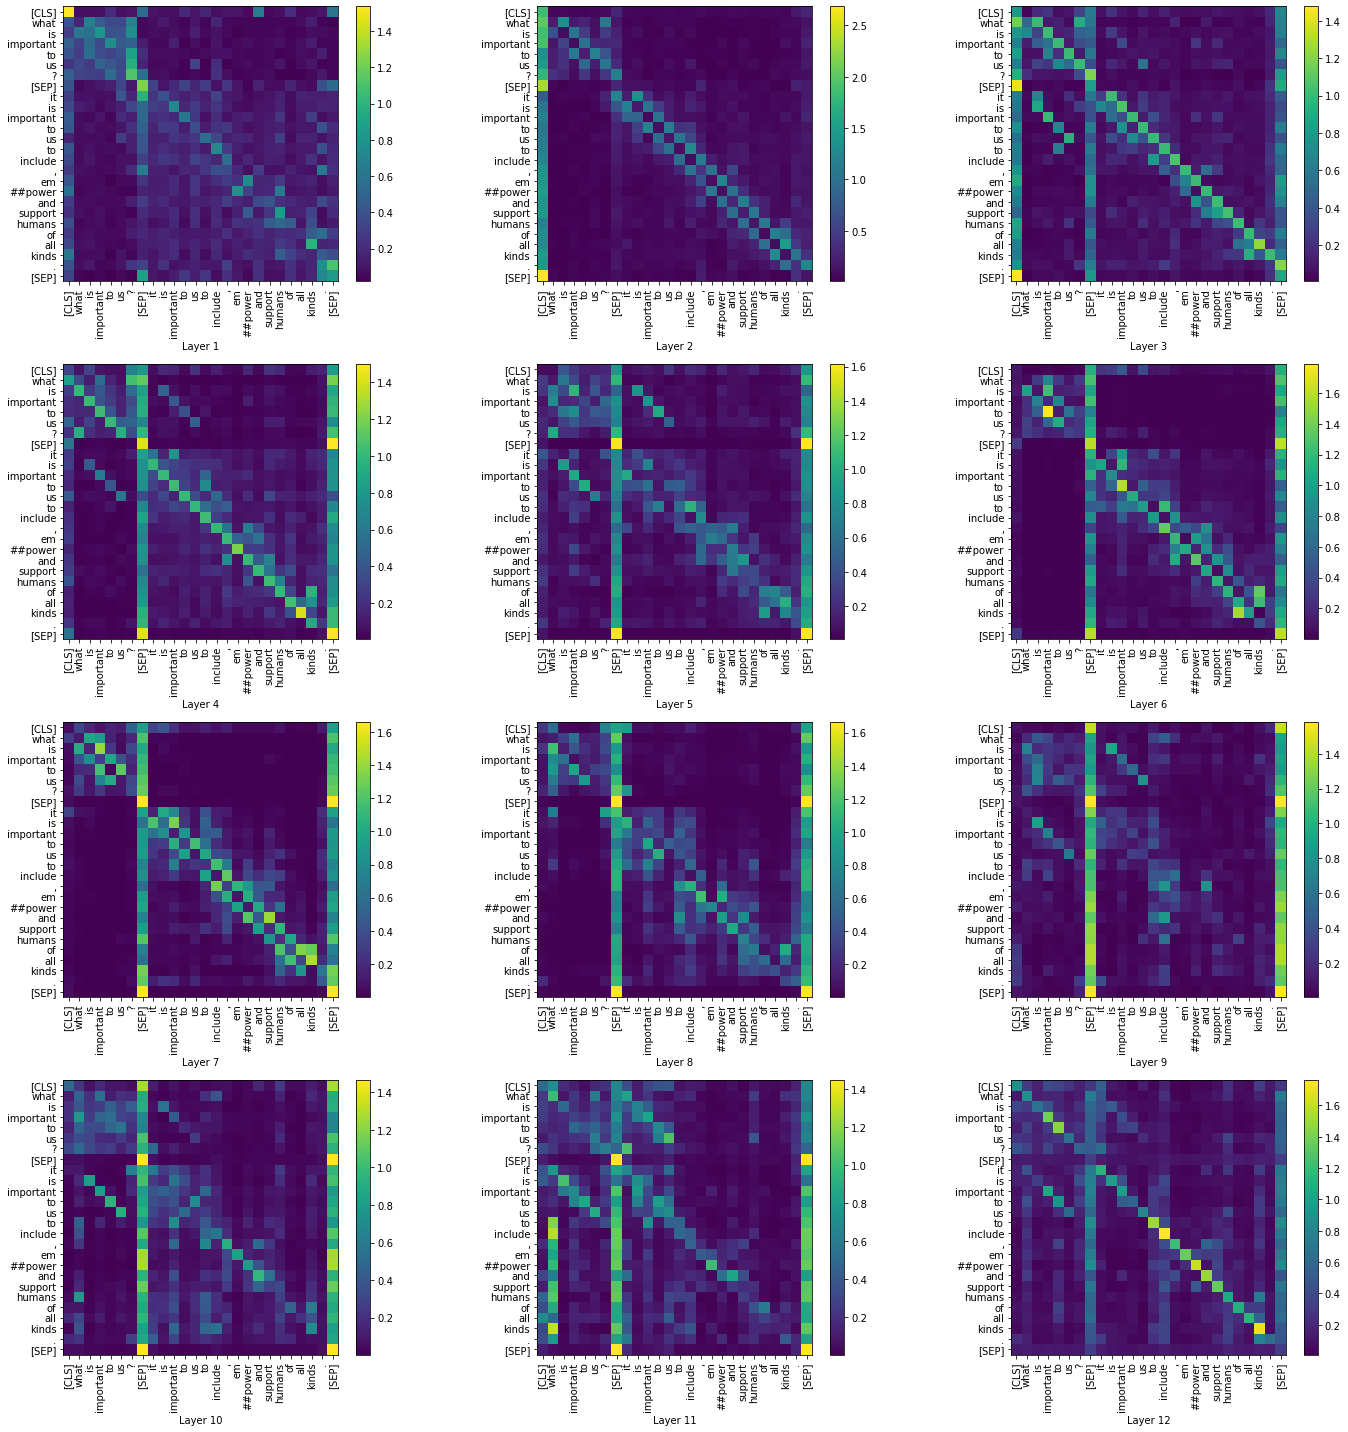

In [17]:
visualize_token2token_scores(torch.norm(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

Based on the visualiziation above we can convice ourselves that attention scores aren't trustworthy measures of importances for token-to-token relations across all layers. We see strong signal along the diagonal and for the `[SEP]` and `[CLS]` tokens. These signals, however, aren't true indicators of what semantic the model learns.


# Visualizing attribution / importance scores

In the cells below we visualize the attribution scores of attention matrices for the start and end position positions prediction and compare with the actual attention matrices. To do so, first of all, we compute the attribution scores using LayerConductance algorithm similar to Part 1.

A helper function to summarize attributions for each word token in the sequence.

In [18]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

# Interpreting BertLayer Outputs and Self-Attention Matrices in each Layer

Now let's look into the layers of our network. More specifically we would like to look into the distribution of attribution scores for each token across all layers and attribution matrices for each head in all layers in Bert model.  
We do that using one of the layer attribution algorithms, namely, layer conductance. However, we encourage you to try out and compare the results with other algorithms as well.


Let's configure `InterpretableEmbeddingsBase` again, in this case in order to interpret the layers of our model.

In [ ]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'bert.embeddings')

Let's iterate over all layers and compute the attributions w.r.t. all tokens in the input and attention matrices. 

Note: Since below code is iterating over all layers it can take over 5 seconds. Please be patient!

In [20]:
layer_attrs_start = []
layer_attrs_end = []

layer_attn_mat_start = []
layer_attn_mat_end = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(token_type_ids, position_ids,attention_mask, 1))
    
    layer_attrs_start.append(summarize_attributions(layer_attributions_start[0]))
    layer_attrs_end.append(summarize_attributions(layer_attributions_end[0]))

    layer_attn_mat_start.append(layer_attributions_start[1])
    layer_attn_mat_end.append(layer_attributions_end[1])

    

In [21]:
# layer x seq_len
layer_attrs_start = torch.stack(layer_attrs_start)
# layer x seq_len
layer_attrs_end = torch.stack(layer_attrs_end)

# layer x batch x head x seq_len x seq_len
layer_attn_mat_start = torch.stack(layer_attn_mat_start)
# layer x batch x head x seq_len x seq_len
layer_attn_mat_end = torch.stack(layer_attn_mat_end)

As a reminder of Part 1 we visualize the heatmaps of the attributions for the outputs of all 12 layers in the plots below. The outputs of 12 layers are also known as context layer which represents the dot product between the attibution matrices and value vector.

The plot below represents a heatmap of attributions across all layers and tokens for the start position prediction.

Note that here we do not have information about different heads. Heads related information will be examined separately when we visualize the attribution scores of the attention matrices w.r.t. the start or end position predictions.

It is interesting to observe that the question word `what` gains increasingly high attribution from layer one to ten. In the last two layers that importance is slowly diminishing.  
In contrary to `what` token, many other tokens have negative or close to zero attribution in the first 6 layers. 

We start seeing slightly higher attribution in tokens `important`, `us` and `to`. Interestingly token `important` is also assigned high attribution score which is remarkably high in the fifth and sixth layers.

Lastly, our correctly predicted token `to` gains increasingly high positive attribution especially in the last two layers.


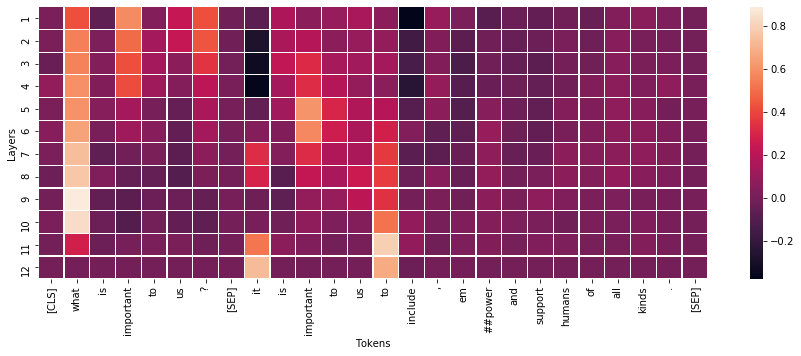

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_start.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

Now let's examine the heat map of the attributions for the end position prediction. In the case of end position prediction we again observe high attribution scores for the token `what` in the last 11 layers.
Correctly predicted end token `kinds` has positive attribution across all layers and it is especially prominent in the last two layers. It's also interesting to observe that `humans` token also has  relatively high attribution score in the last two layers.

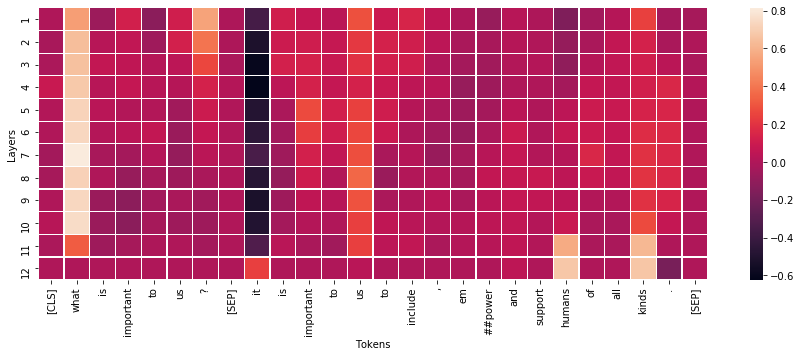

In [23]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(layer_attrs_end.cpu().detach().numpy(), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

It is interesting to note that when we compare the heat maps of start and end position, overall the colors for start position prediction on the map have darker intensities. This implies that there are less tokens that attribute positively to the start position prediction and there are more tokens which are negative indicators or signals of start position prediction.

# Interpreting Attribution Scores for Attention Matrices

In this section we visualize the attribution scores of start and end position predictions w.r.t. attention matrices.
Note that each layer has 12 heads, hence attention matrices. We will first visualize for a specific layer and head, later we will summarize across all heads in order to gain a bigger picture.


Below we visualize the attribution scroes of 12 heads for selected layer `layer` for start position prediction.

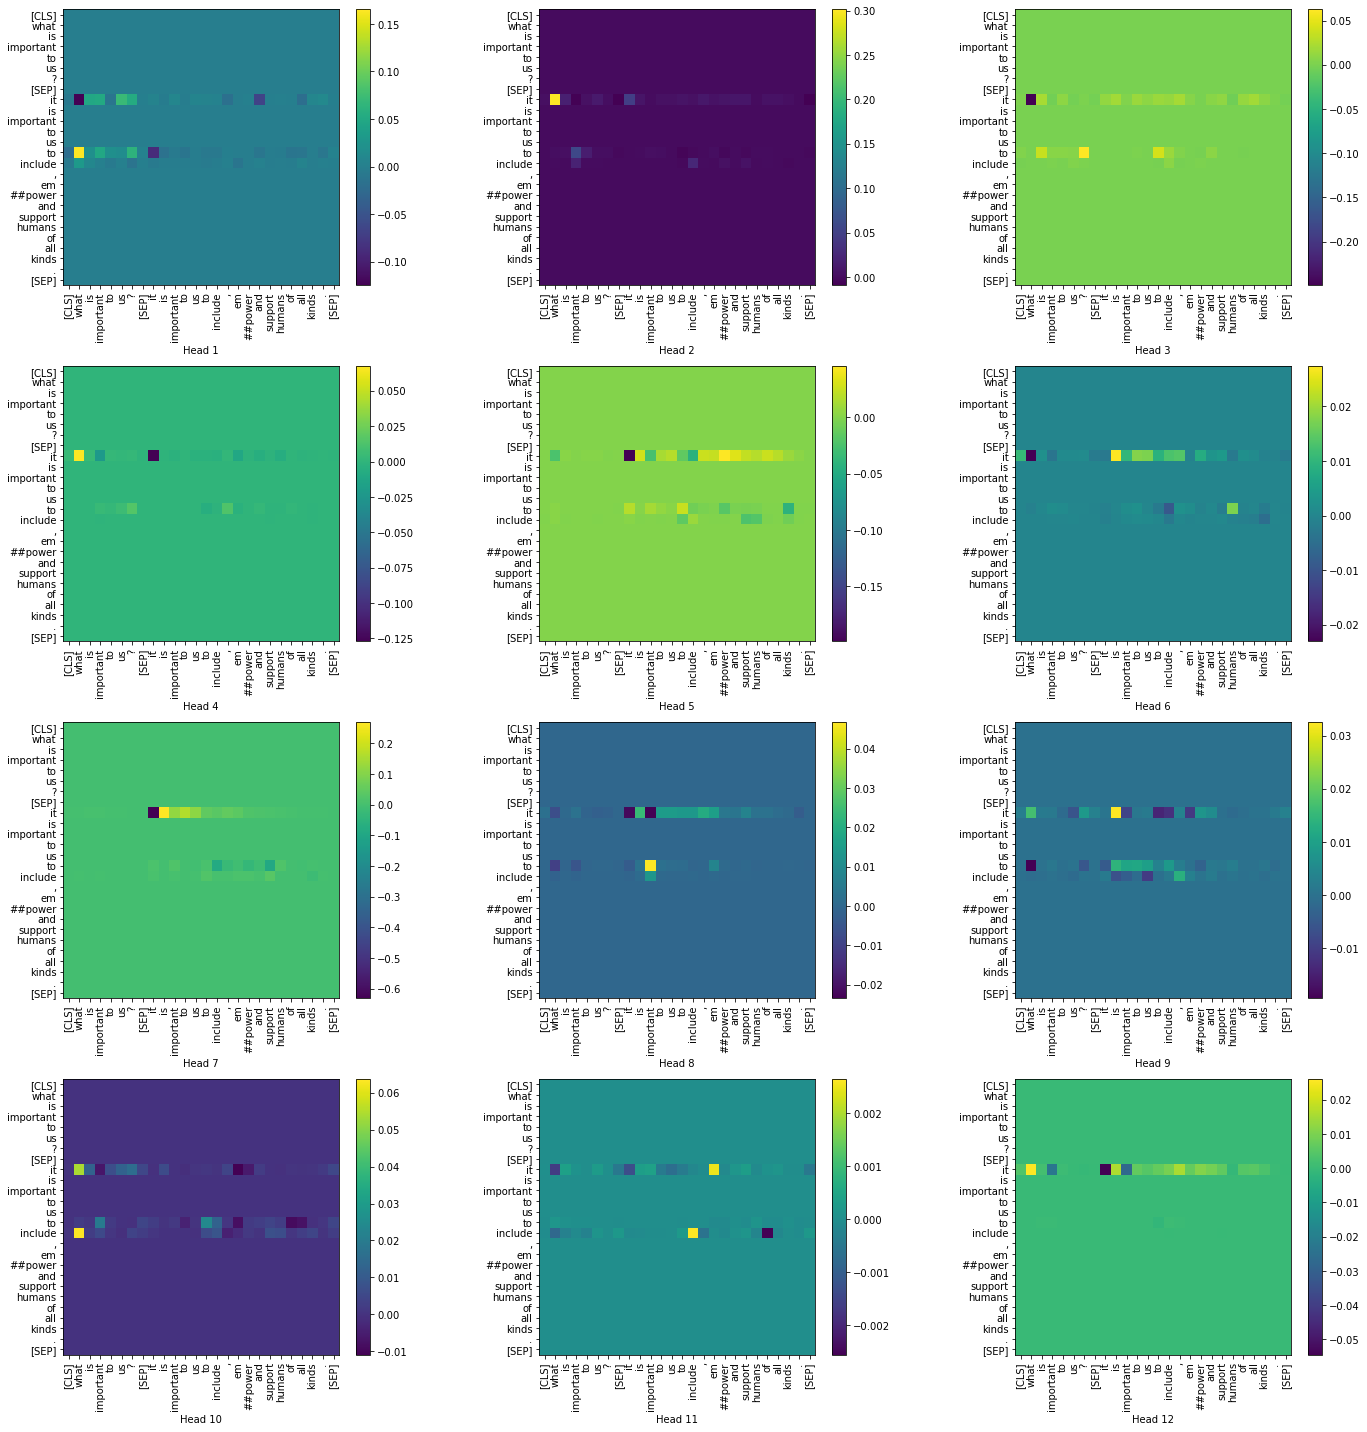

In [24]:
visualize_token2token_scores(layer_attn_mat_start[layer].squeeze().cpu().detach().numpy())

As we can see from the visualizations above, in contrary to attention scores the attributions of specific target w.r.t. to those scores are more meaningful and most importantly, they do not attend to `[SEP]` token or show diagal patterns. We observe that heads 4, 9, 12 and 2 learn strong relationship between `what` and `it` tokens, head 10 learns strong relationship between `what` and `include`, heads 3, 8 between `important` and `to` and head 1 between `to` and `what`. Note that `to` token is the start position of the answer token. It is also important to mention that these observations are for a selected `layer`. We can change the index of selected `layer` and examine interesting relationships in other layers.

In the cell below we visualize the attention attribution scores normalized across the head axis.

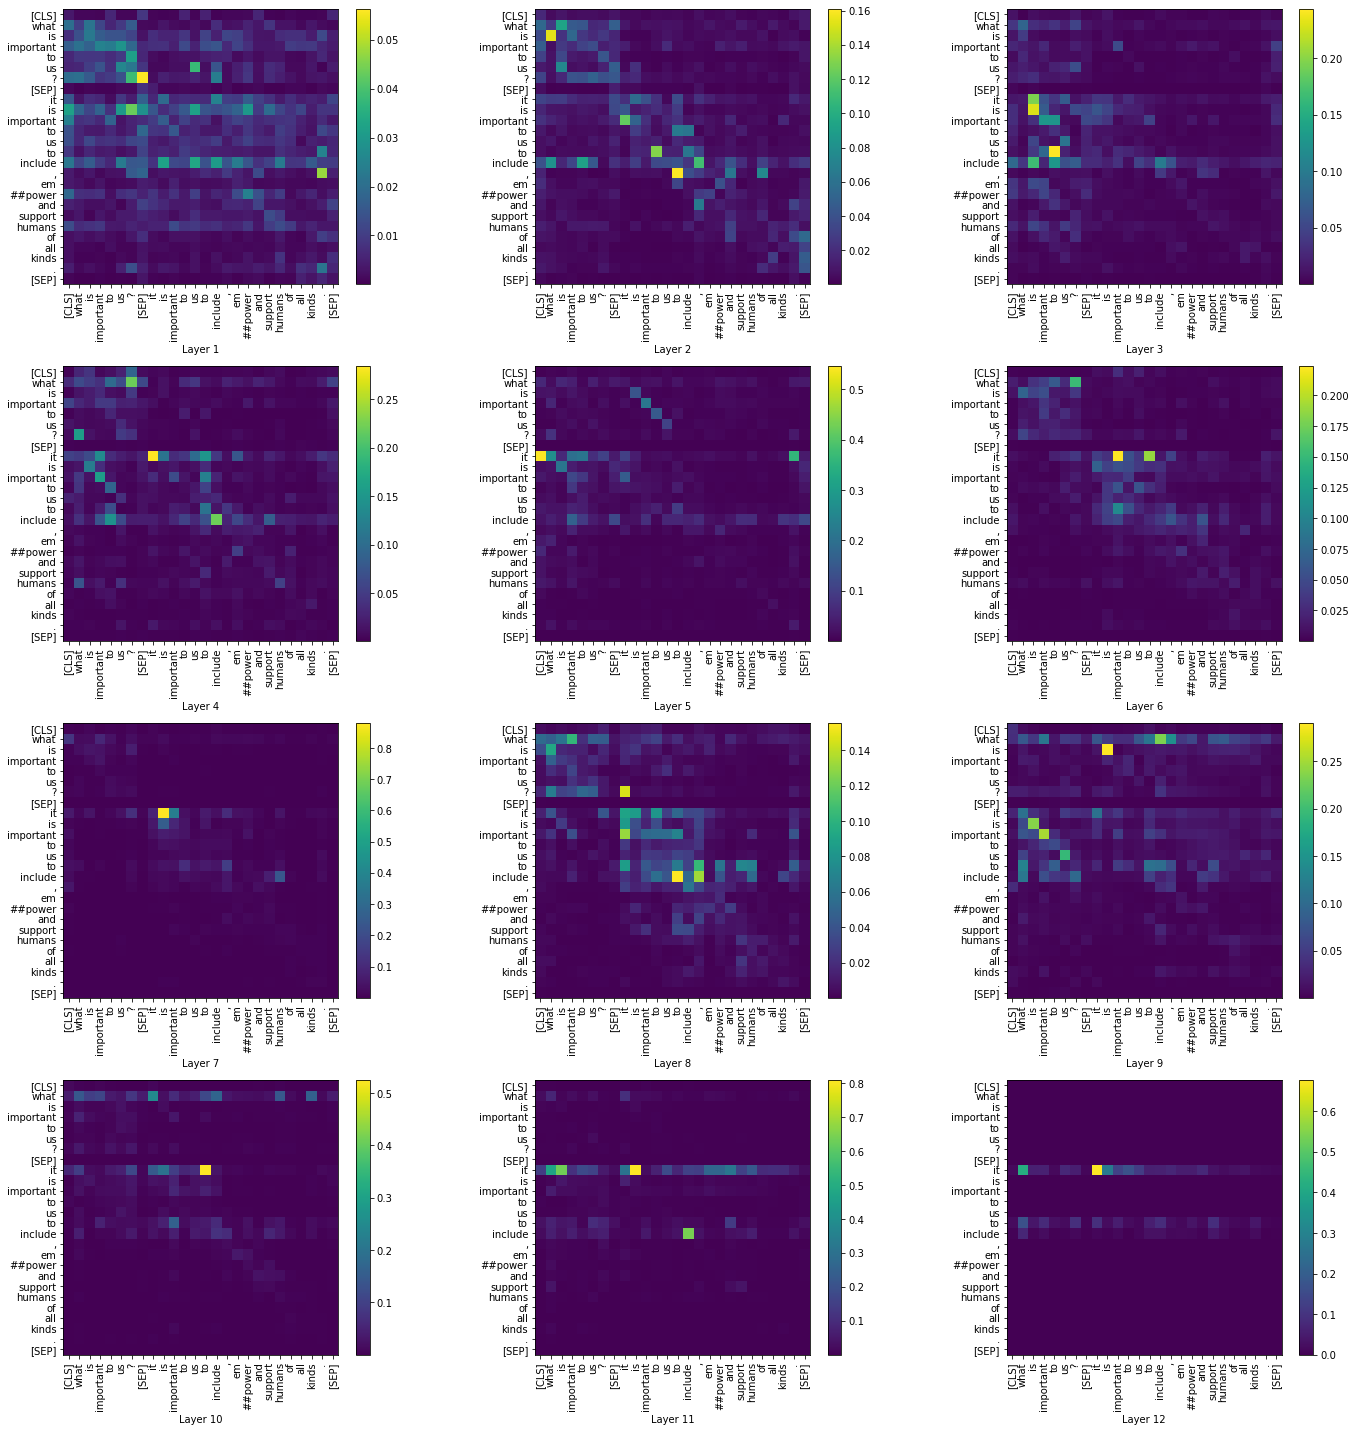

In [25]:
visualize_token2token_scores(torch.norm(layer_attn_mat_start, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

By looking at the visualizations above we can see that the model pays attention to very specific handpicked relationships. Most notably in the layers 10, 7, 12 and 4 it focuses more on the relationships between `it` and `is`, `important` and `to`.

Now let's run the same experiments for the end position prediction. Below we visualize the attribution scorese of attention matrices for the end position prediction for the selected `layer`.

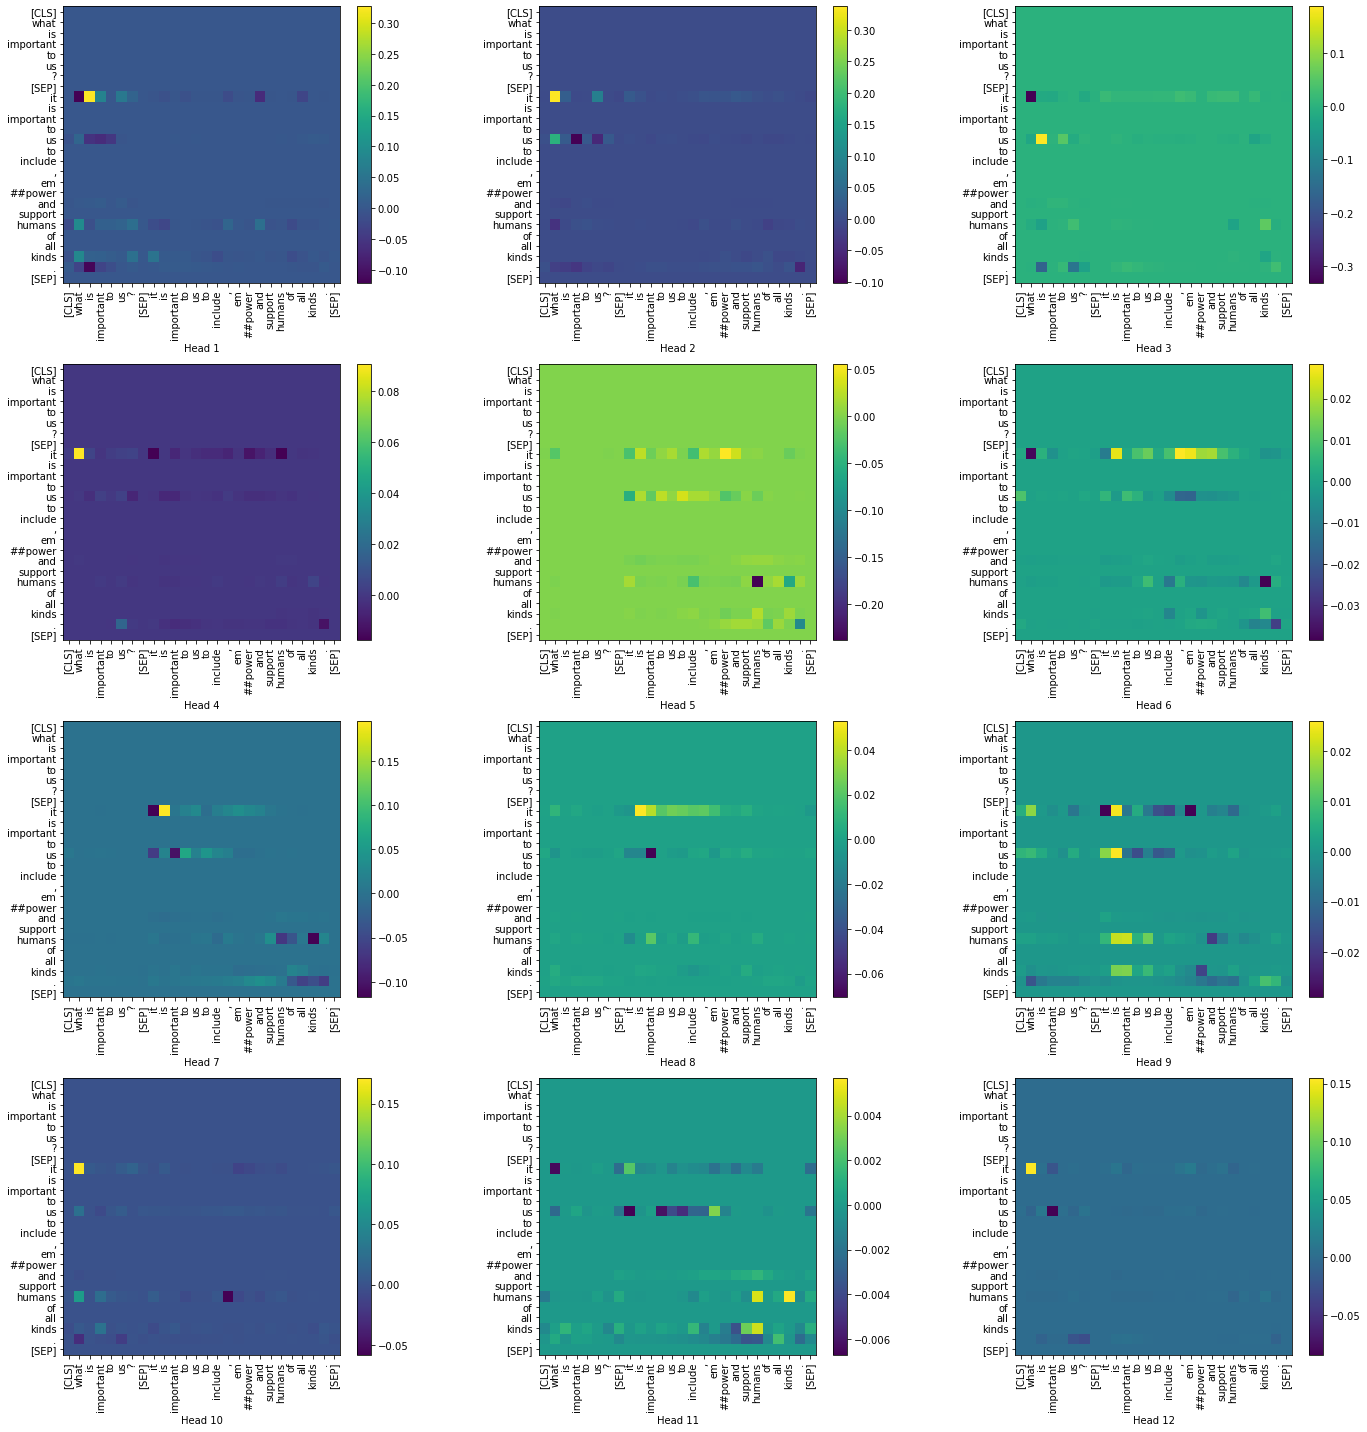

In [26]:
visualize_token2token_scores(layer_attn_mat_end[layer].squeeze().cpu().detach().numpy())

As we can see from the vislualizations above that for the end position prediction we have stronger attention towards the end of the answer token `kinds`. Here we can see stronger connection between `humans` and `kinds` in the 11th head, `it` and `em`, `power`, `and` in the 5th, 6th and 8th heads. The connections between `it` and `what` are also strong in first couple and 10th heads.

Similar to start position let's visualize the norm across all heads for each layer.

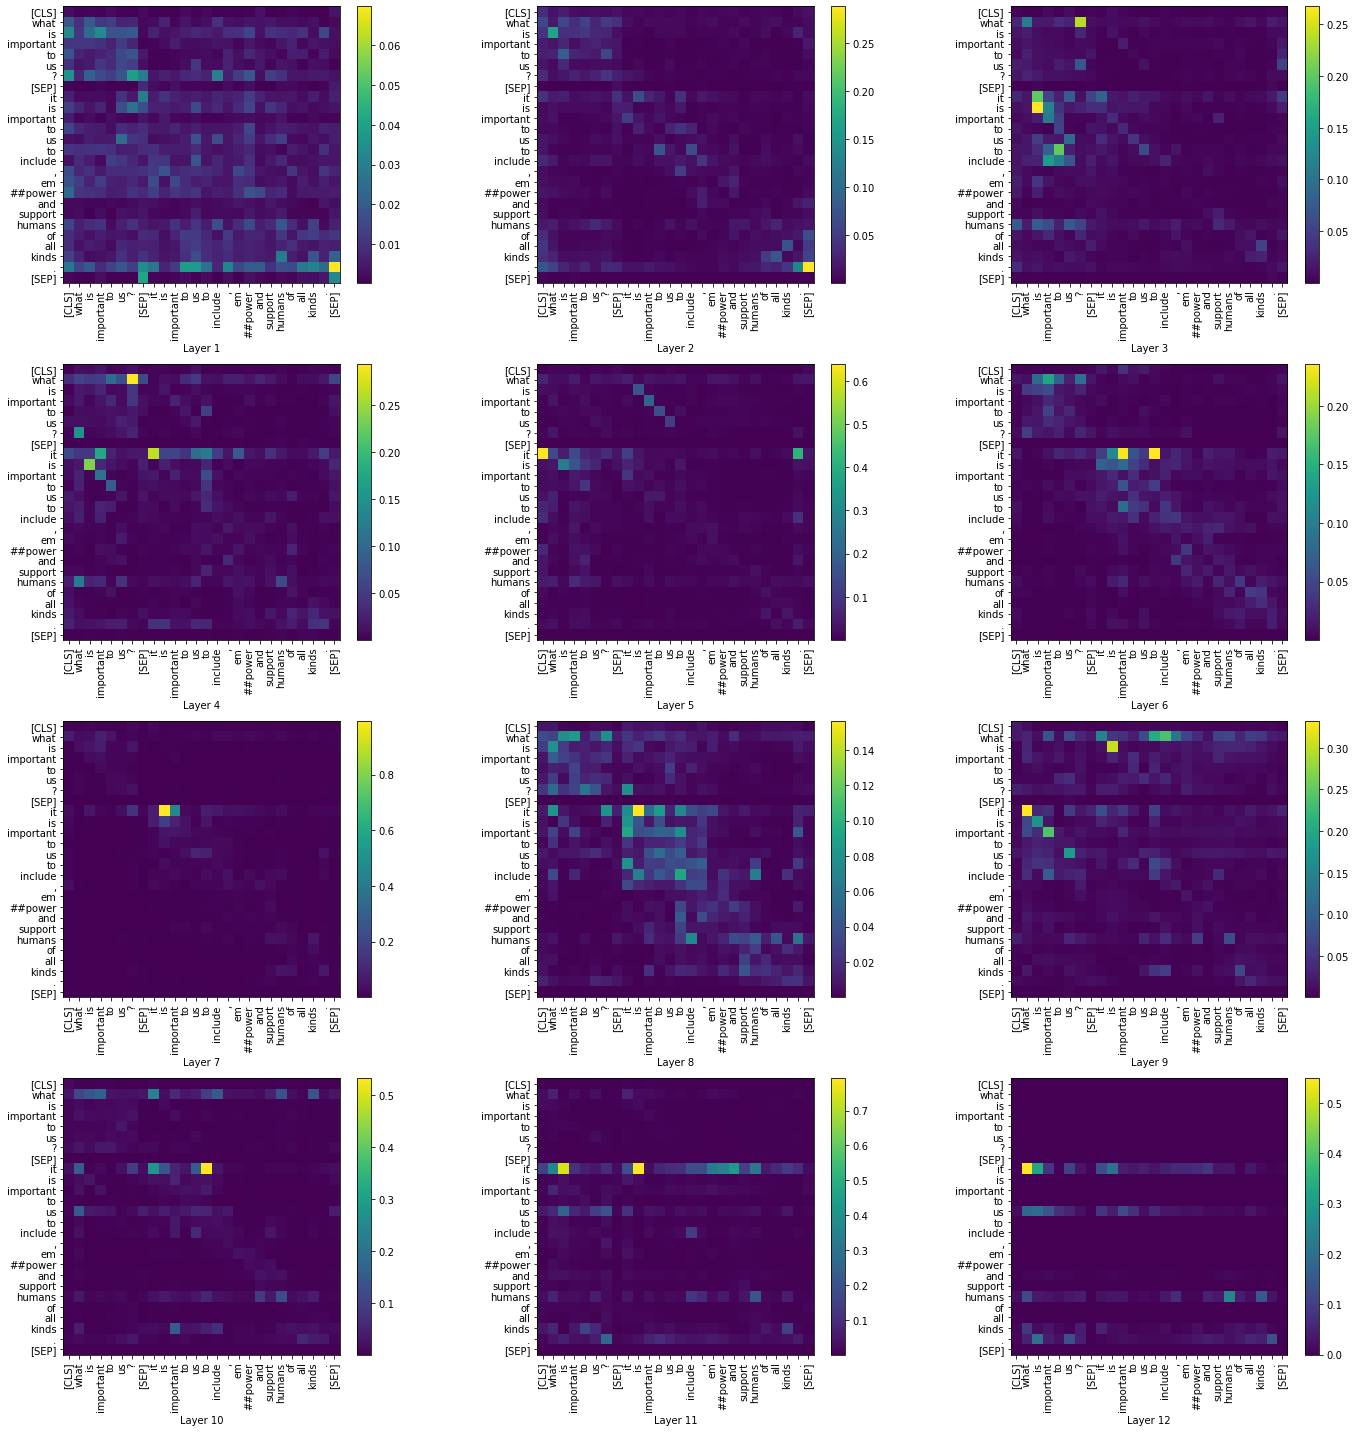

In [27]:
visualize_token2token_scores(torch.norm(layer_attn_mat_end, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

As we can see from the visualizations above for the end position prediction there is a relation learnt between `[SEP]` and `.` in first and second layers. Also we observe that `it` token is strongly related to `what`, `important` and `to`.

# Computing and Visualizing Vector Norms

In this section of the tutorial we will compute Vector norms for activation layers such as ||f(x)||, ||α * f(x)|| and ||Σαf(x)|| as also described in the: https://arxiv.org/pdf/2004.10102.pdf

As also shown in the paper mentioned above, normalized activations are better indicators of importance scores than the attention scores however they aren't as indicative as the attribution scores. This is because normalized activations ||f(x)|| and ||α * f(x)|| aren't attributed to a specific output prediction. From our results we can also see that according to those normalized scores `[SEP]` tokens are insignificant.

Below we define / extract all parameters that we need to computation of vector norms. 

In [28]:
output_attentions_all_shape = output_attentions_all.shape

batch = output_attentions_all_shape[1]
num_heads = output_attentions_all_shape[2]
head_size = 64
all_head_size = 768


In order to compute above mentioned norms we need to get access to dense layer's weights and value vector of the self attention layer.

#### Getting Access to Value Activations 

Let's define the list of all layers for which we would like to access Value Activations.

In [29]:
layers = [model.bert.encoder.layer[layer].attention.self.value for layer in range(len(model.bert.encoder.layer))]

We use `Captum`'s LayerActivation algorithm to access the outputs of all `layers`.

In [30]:
la = LayerActivation(squad_pos_forward_func, layers)

value_layer_acts = la.attribute(input_embeddings, additional_forward_args=(token_type_ids, position_ids, attention_mask))
# shape -> layer x batch x seq_len x all_head_size
value_layer_acts = torch.stack(value_layer_acts)

In the cell below we perform several transformations with the value layer activations and bring it to the shape so that we can compute different norms. The transformations are done the same way as it is described in the original paper and corresponding github implementation.

In [31]:
new_x_shape = value_layer_acts.size()[:-1] + (num_heads, head_size)
value_layer_acts = value_layer_acts.view(*new_x_shape)

# layer x batch x neum_heads x 1 x head_size
value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4)

value_layer_acts = value_layer_acts.permute(0, 1, 3, 2, 4).contiguous()
value_layer_acts_shape = value_layer_acts.size()

# layer x batch x seq_length x num_heads x 1 x head_size
value_layer_acts = value_layer_acts.view(value_layer_acts_shape[:-1] + (1, value_layer_acts_shape[-1],))

print('value_layer_acts: ', value_layer_acts.shape)

value_layer_acts:  torch.Size([12, 1, 26, 12, 1, 64])


#### Getting Access to Dense Features 

Not let's transform dense features so that we can use them to compute ||f(x)|| and ||α * f(x)||.

In [32]:
dense_acts = torch.stack([dlayer.attention.output.dense.weight for dlayer in model.bert.encoder.layer])

dense_acts = dense_acts.view(len(layers), all_head_size, num_heads, head_size)

# layer x num_heads x head_size x all_head_size
dense_acts = dense_acts.permute(0, 2, 3, 1).contiguous()

Computing f(x) score by multipying the value vector with the weights of the dense vector for all layers.

In [33]:
# layers, batch, seq_length, num_heads, 1, all_head_size
f_x = torch.stack([value_layer_acts_i.matmul(dense_acts_i) for value_layer_acts_i, dense_acts_i in zip(value_layer_acts, dense_acts)])
f_x.shape

torch.Size([12, 1, 26, 12, 1, 768])

In [34]:
# layer x batch x seq_length x num_heads x 1 x all_head_size)
f_x_shape = f_x.size() 
f_x = f_x.view(f_x_shape[:-2] + (f_x_shape[-1],))
f_x = f_x.permute(0, 1, 3, 2, 4).contiguous() 

#(layers x batch, num_heads, seq_length, all_head_size)
f_x_shape = f_x.size() 

#(layers x batch, num_heads, seq_length)
f_x_norm = torch.norm(f_x, dim=-1)


Now let's visualize ||f(x)|| scores for all layers and examine the distribution of those scores.

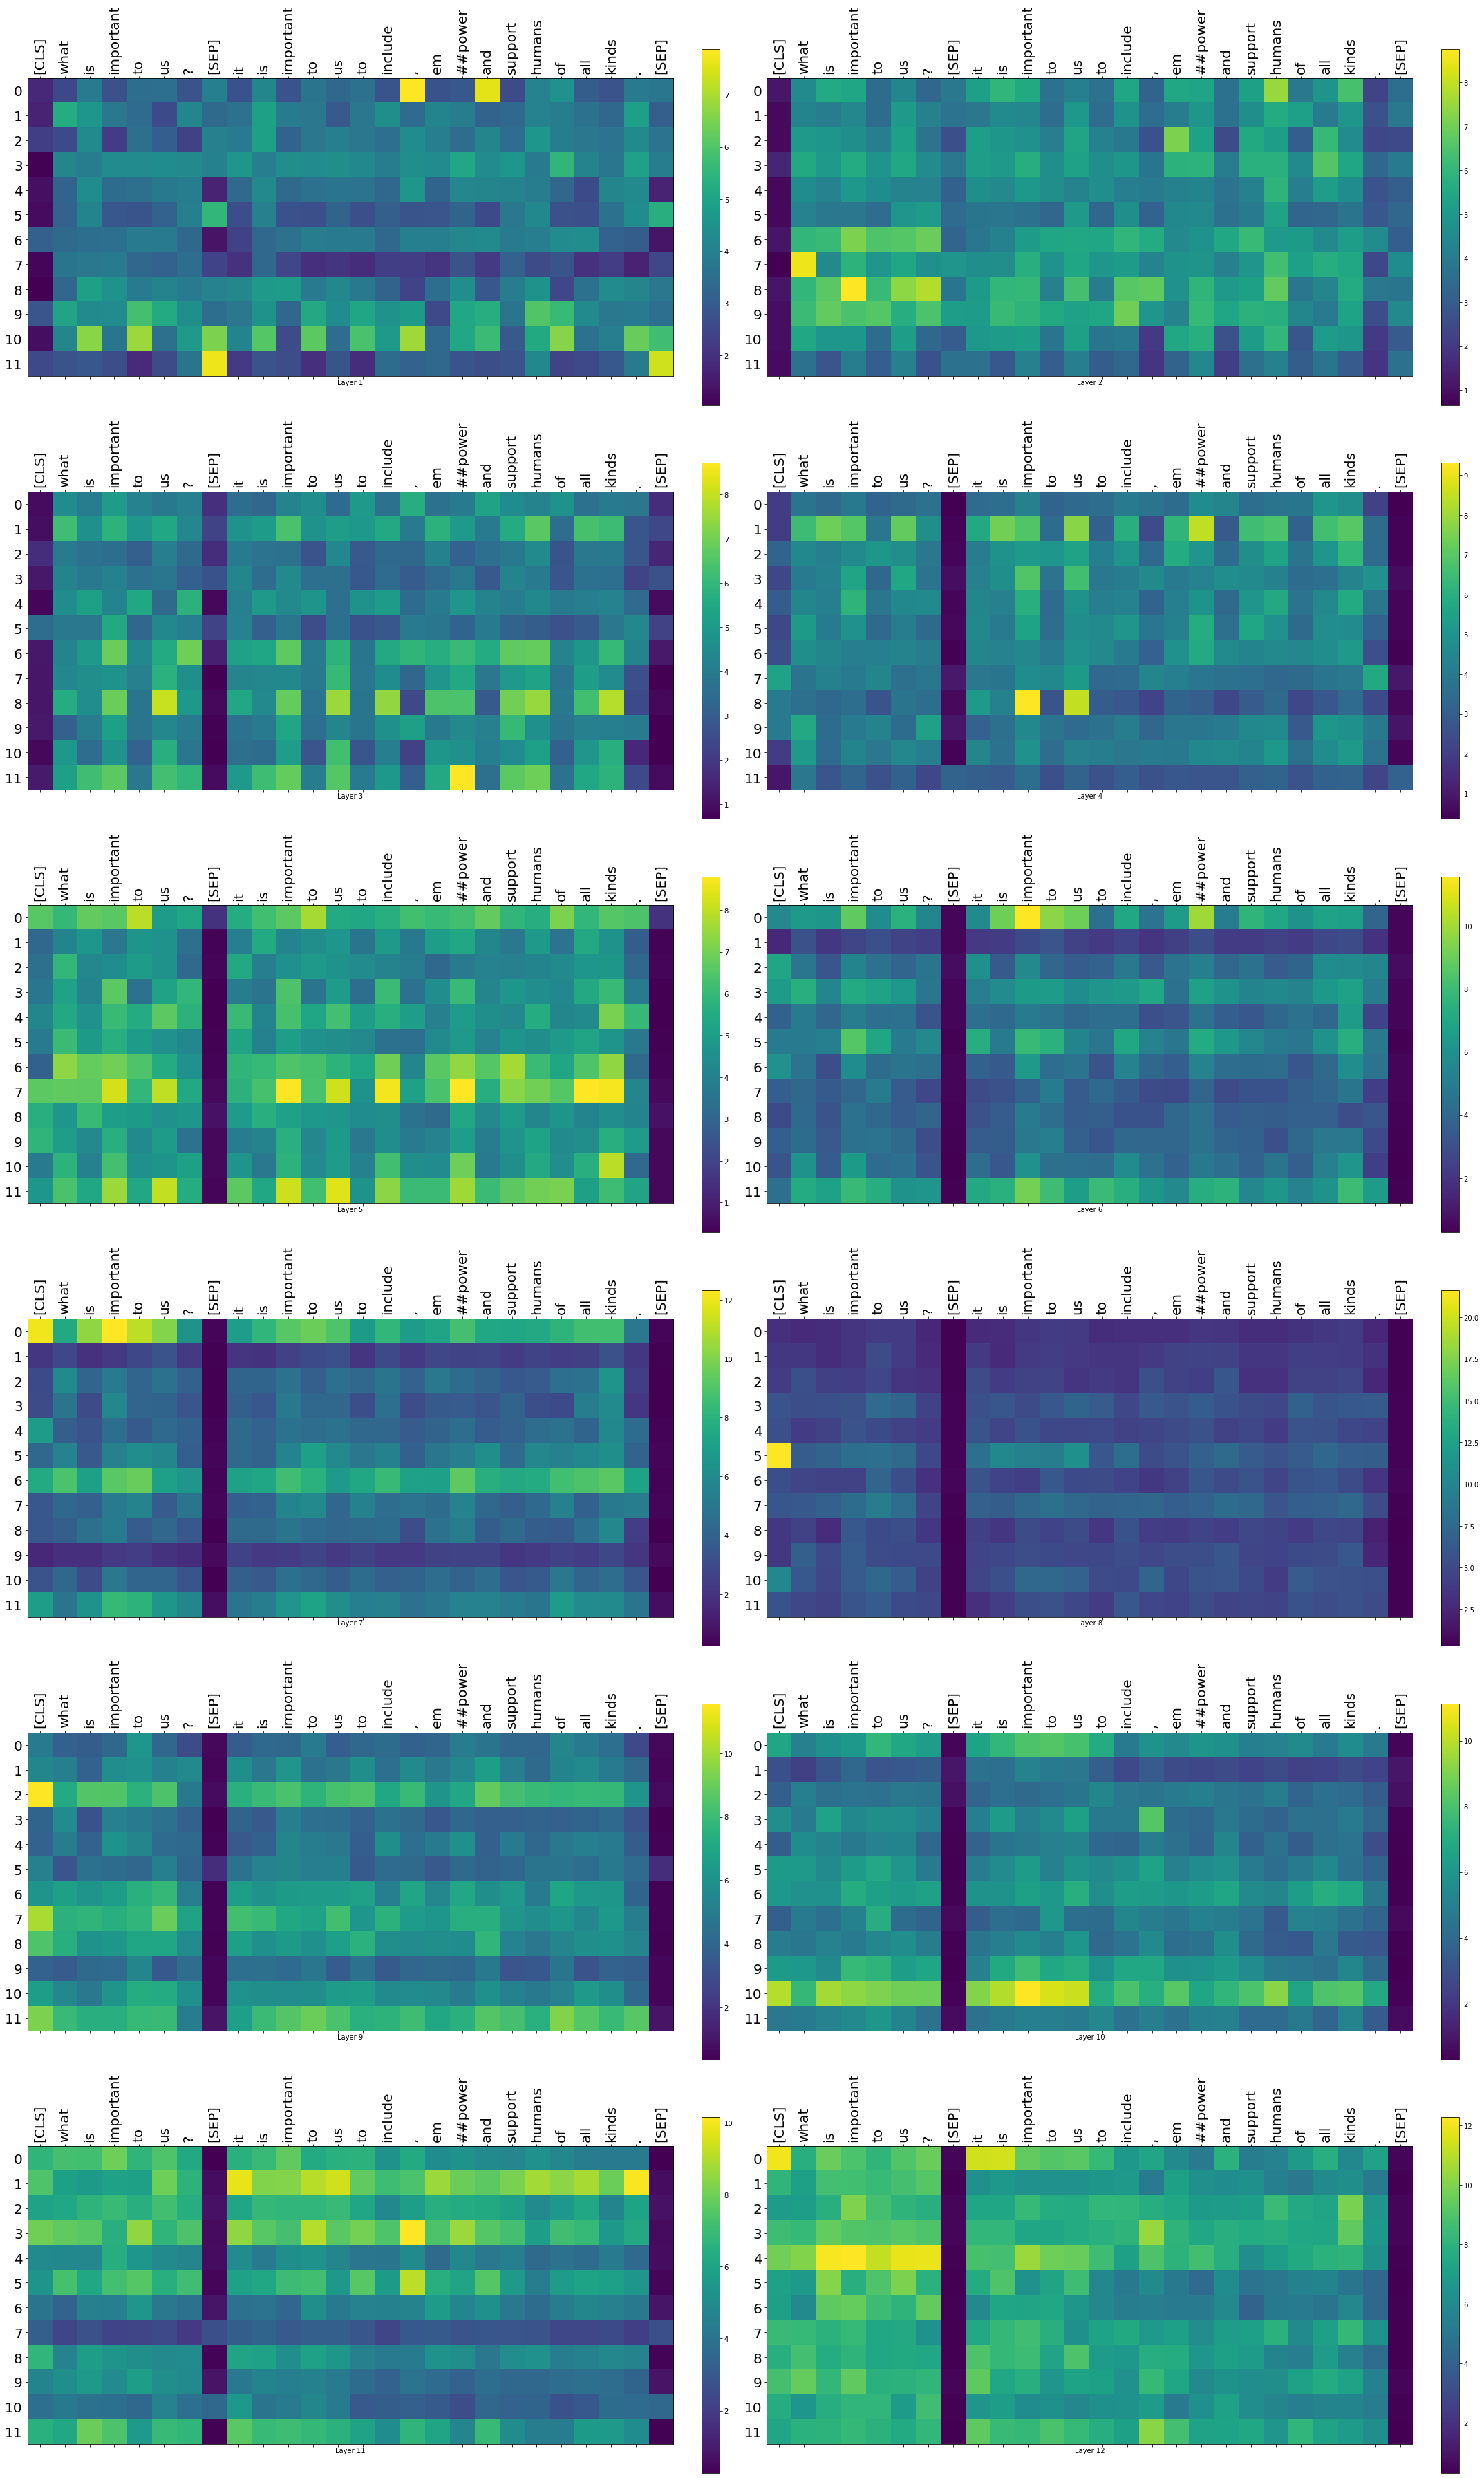

In [35]:
visualize_token2head_scores(f_x_norm.squeeze().detach().cpu().numpy())

When we examine ||f(x)|| scores for all layers we can easily see that the `[SEP]` token receives the lowest score across all layers. This is one of the conclusions that the original paper came to. In terms of other tokens we can see that the heads in different layers focus on different parts of the input sentence.

Now let's compute ||α * f_x||. This computation is performed using the original paper's technique with the help of einsum operator.

In [36]:
# layer x batch x num_heads x seq_length x seq_length x all_head_size
alpha_f_x = torch.einsum('lbhks,lbhsd->lbhksd', output_attentions_all, f_x)

# layer x batch x num_heads x seq_length x seq_length
alpha_f_x_norm = torch.norm(alpha_f_x, dim=-1)

Let's now visualize ||α * f_x|| scores for the layer with index `layer`.

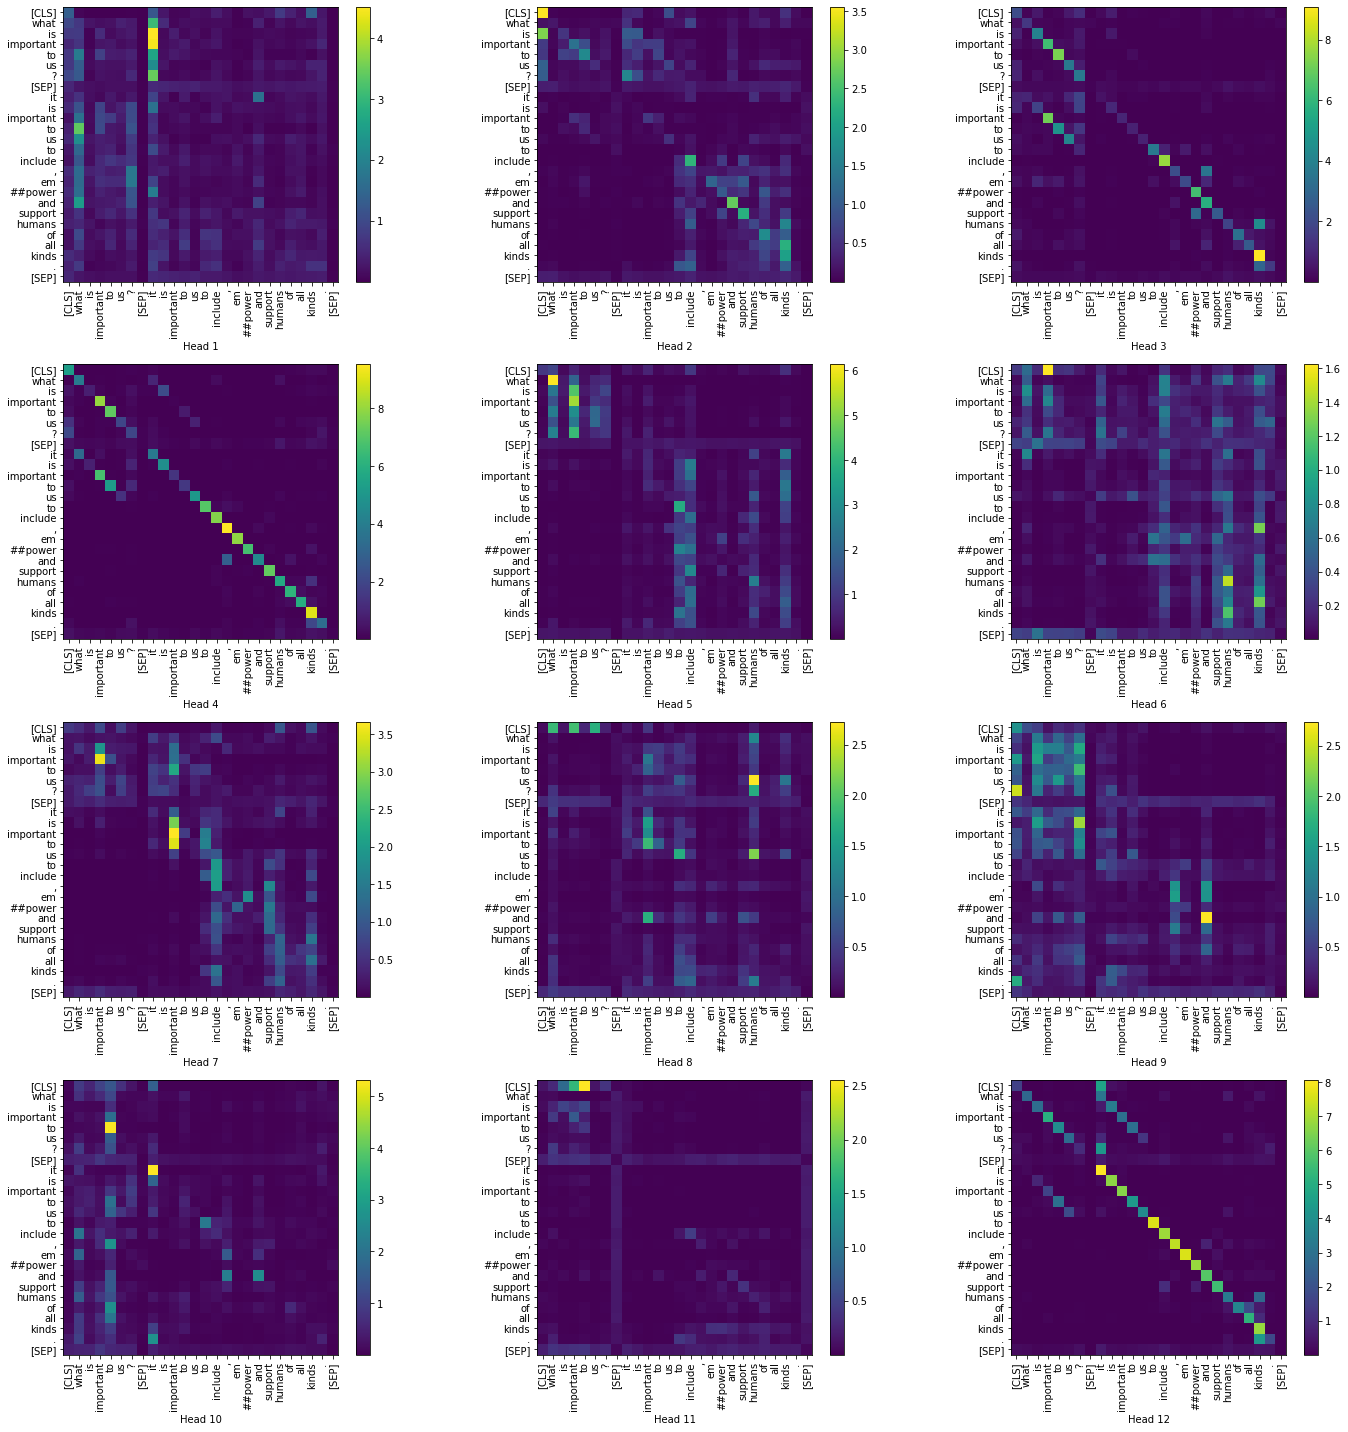

In [37]:
visualize_token2token_scores(alpha_f_x_norm[layer].squeeze().detach().cpu().numpy())

As we can see from the visualizations above there is no strong attention to `[SEP]` or `[CLS]` tokens. Some of the heads show diagonal patterns and some of them show strong attention between specific pairs of tokens.

Now let's compute the summed norm across `num_heads` axis ||Σαf(x)|| and visualize normalized scores for each layer.

In [38]:
summed_alpha_f_x = alpha_f_x.sum(dim=2)

# layers x batch x seq_length x seq_length
summed_alpha_f_x_norm = torch.norm(summed_alpha_f_x, dim=-1)


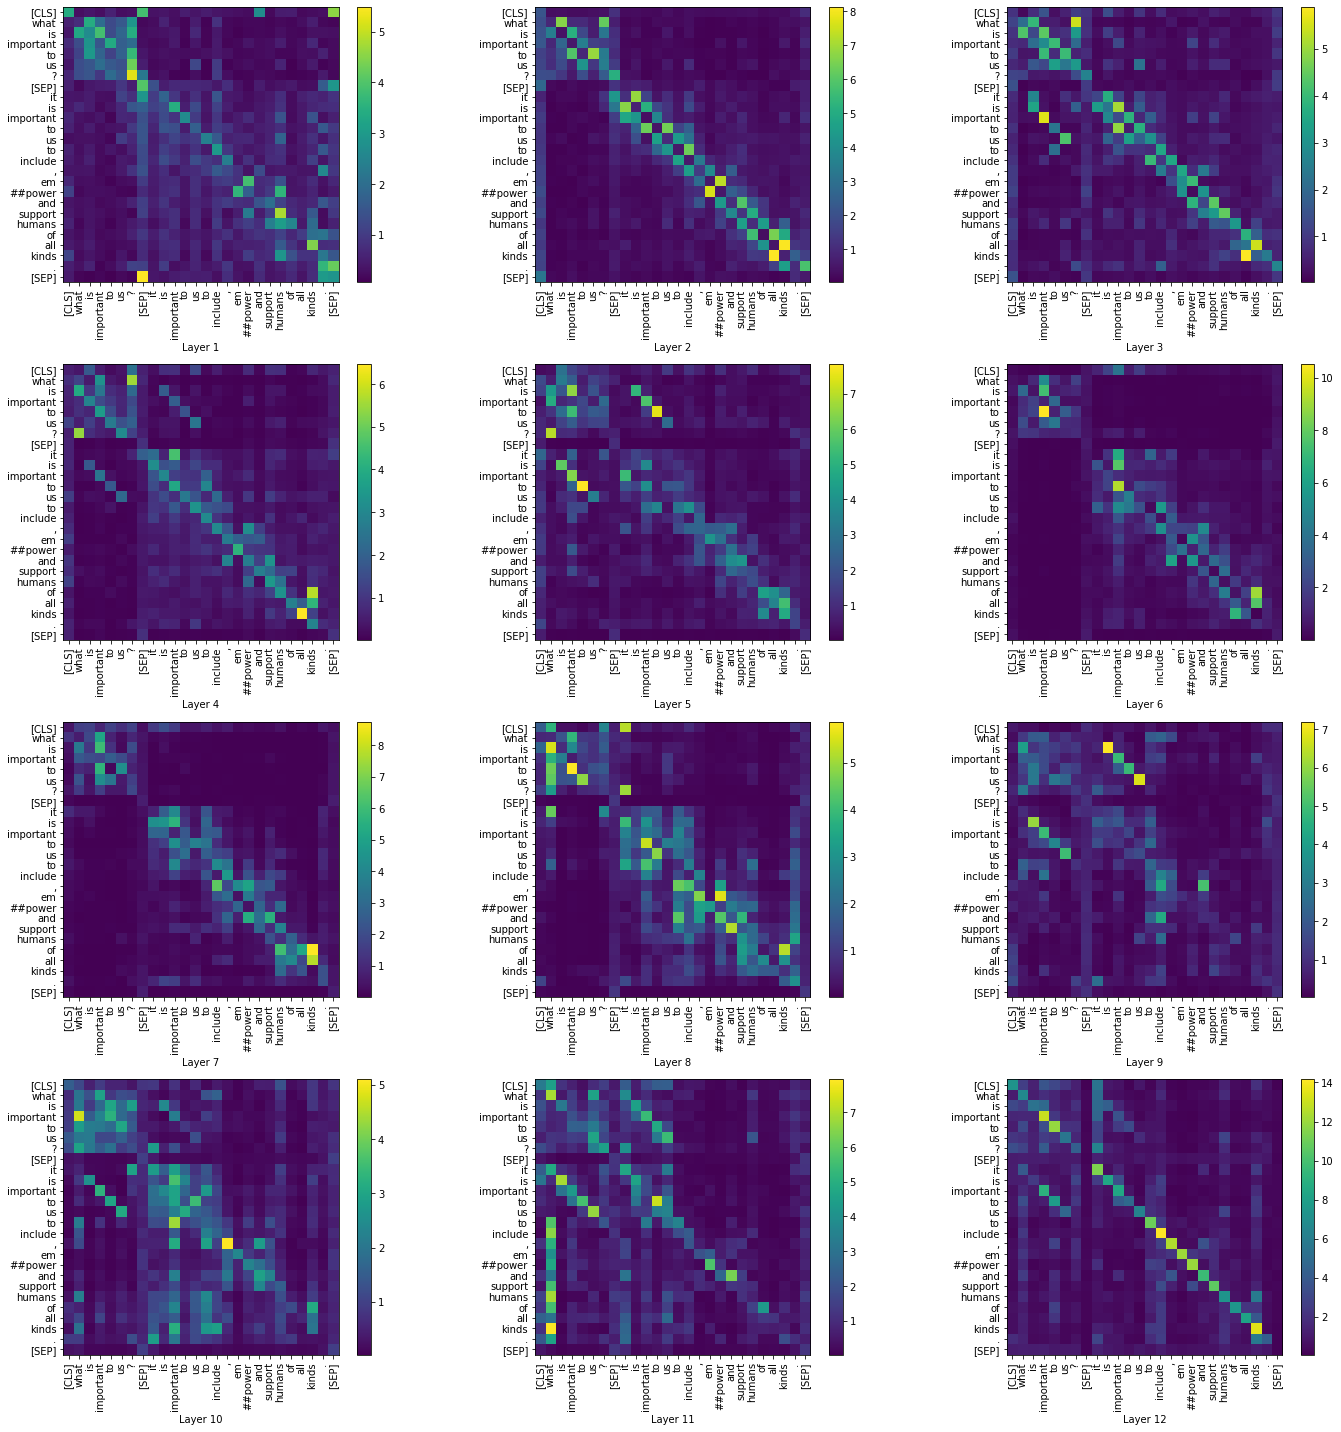

In [39]:
visualize_token2token_scores(summed_alpha_f_x_norm.squeeze().cpu().detach().numpy(), x_label_name='Layer')

Above visualizations also confirm that the attention scores aren't concentrated on the tokens such as `[CLS]`, `[SEP]` and `.` however we see stronger signals along the diagonals and some patches of stronger signals between certain parts of the text including some tokens in the question part that are relevant in the answer piece.

It is important to mention that all experiments were performed for one input sample, namely, `sentence`. In the papers we often see aggregation of the results across multiple samples. For further analysis and more convincing propositions we recommend to conduct the experments across multiple input samples. In addition to that it would be also interesting to look into the correlation of heads in layer and across different layers.